# Project 7 - Image classification using CNNs in Keras

###1. Import the libraries, load dataset, print shape of data, visualize the images in dataset.

In [3]:
#importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from sklearn import metrics

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

In [5]:
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive

In [8]:
#mounting google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
#loading images.npy to images variable
images=np.load('/content/drive/My Drive/Colab Notebooks/images.npy')

In [10]:
#loading labels
#labels are first read into pandas dataframe, then converted into numpy
labels_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Labels.csv', sep=',',header=None)
labels=labels_df.to_numpy()

In [11]:
#shape of the loaded data into images variable
images.shape

(4750, 128, 128, 3)

images array is composed of 4750 arrays of 128x128 elements, each elemement being of size 3. It means there are 4750 images, each one being 128x128 pixels and there are 3 channels of red, green, blue. 

In [26]:
#shape of the labels variable
labels.shape

(4751, 1)

In [27]:
#what is on 0th place of labels variable
labels[0]

array(['Label'], dtype=object)

Since there is 'Label' on the 0th place of the labels array, a new array is derived from existing one by omitting 0th value.

In [28]:
labels=labels[1:len(labels)]

In [29]:
labels.shape

(4750, 1)

In [30]:
#this funtion visualize images.
#as input an array of images is taken, labels, nr_of_images
def image_showing(array_of_images, labels, nr_of_images):
  
  #index random generator
  #first nr_of_images random numbers are generated
  indexes=np.random.rand(nr_of_images)
  #random numbers multiplied with shape of labels to get values between first and last array member 
  indexes=indexes*labels.shape[0]
  #rounding randomly generated numbers and cobverting it to int
  indexes=indexes.round().astype('int')
  
  #loop to print label and plot image
  for index in indexes:
    print(labels[index])
    cv2_imshow(array_of_images[index])
  #function returns array of indexes of images shown
  return(indexes)

Now labels array correspond to images array. In next step first visualisation will be performed.

['Common Chickweed']


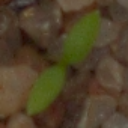

['Sugar beet']


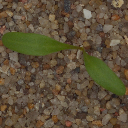

['Sugar beet']


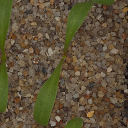

['Small-flowered Cranesbill']


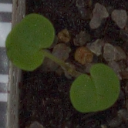

['Common wheat']


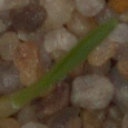

array([1618, 3473, 3370,  344, 1207])

In [31]:
#showing several images by calling function image_showing()
image_showing(images, labels, 5)

###2. Data Pre-processing:

Normalization will be performed as a last step, since visualisation of the image after such action is useless - all pixels will be either 1 or 0 - close to or equal to black. In addition, there will be nothing to blur on such image. As a result, first Gaussian blur is applied, then images are visualized, then normalization is done by dividing every element of images array with 255.0. Before such division, array must be casted to float32 dtype, since division with 255 would create float number as a result. 

####b. Gaussian Blurring.


In [32]:
#creating a new numpy array as copy of the images array
blured_images=np.copy(images)

In [33]:
#applying GaussianBlur filter on arrays in blured_images
#loop goes through images array
for idx, img in enumerate(images):
  #GaussianBlur function of the cv2 module is applied for bluring the images. Every new element of the blur  
  blured_images[idx]=cv2.GaussianBlur(img, (5,5),0)

#### Visualizing images after bluring:

['Loose Silky-bent']


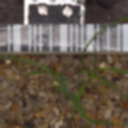

['Shepherds Purse']


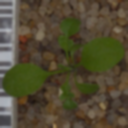

['Cleavers']


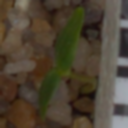

['Charlock']


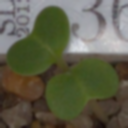

['Scentless Mayweed']


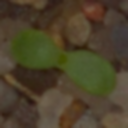

array([4494, 1038, 2440, 2107, 2758])

In [34]:
#image_showing function is used here as well. Images are picked ramdomly as per image_showing() function
image_showing(blured_images, labels, 5)

###a. Normalization.

In [35]:
#normalization of blured_images array (by dividing it with 255)
#before normalization, it has to be casted to float datatype
blured_images=blured_images.astype('float32')/255.0

Let's see values of blured normalized images array

In [36]:
blured_images[0]

array([[[0.14117648, 0.2       , 0.2901961 ],
        [0.15294118, 0.21176471, 0.29803923],
        [0.1882353 , 0.24705882, 0.3254902 ],
        ...,
        [0.30588236, 0.36862746, 0.43137255],
        [0.30588236, 0.3647059 , 0.42745098],
        [0.30588236, 0.3647059 , 0.42745098]],

       [[0.14509805, 0.20392157, 0.2901961 ],
        [0.16078432, 0.21960784, 0.3019608 ],
        [0.2       , 0.2627451 , 0.3372549 ],
        ...,
        [0.30980393, 0.36862746, 0.43137255],
        [0.30980393, 0.36862746, 0.42745098],
        [0.30980393, 0.3647059 , 0.42352942]],

       [[0.14901961, 0.21176471, 0.29411766],
        [0.17254902, 0.23529412, 0.30980393],
        [0.22352941, 0.28627452, 0.35686275],
        ...,
        [0.30980393, 0.3647059 , 0.42352942],
        [0.30980393, 0.36862746, 0.42352942],
        [0.30980393, 0.36862746, 0.42352942]],

       ...,

       [[0.15294118, 0.21176471, 0.2784314 ],
        [0.15686275, 0.21568628, 0.28235295],
        [0.16470589, 0

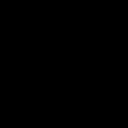

In [37]:
#visualizing one normalized image
cv2_imshow(blured_images[100])

As expected after the normalisation is applied (division by 255), image can no longer be seen - all of the pixels of all 3 channels have values between 0 and 1, hence black color is visible.

###c. Visualize data after pre-processing.

In [38]:
#generating an array of labels for plotting
labels_to_plot=[]
for i in labels:
  labels_to_plot.append(i[0])

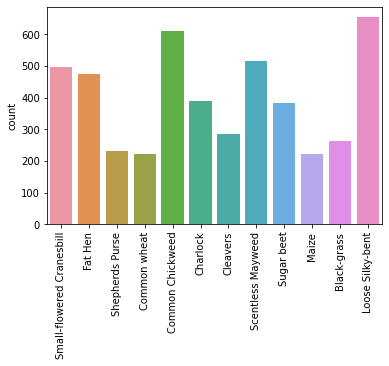

In [39]:
#countplot of target variable
plot=sns.countplot(labels_to_plot)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

It can be easily seen from the graph above that target variable is not perfectly balanced, however, all of the classes are represented in a dataset with the same level of magnitude.

In [48]:
blured_images[0,:,:,0]

array([[0.14117648, 0.15294118, 0.1882353 , ..., 0.30588236, 0.30588236,
        0.30588236],
       [0.14509805, 0.16078432, 0.2       , ..., 0.30980393, 0.30980393,
        0.30980393],
       [0.14901961, 0.17254902, 0.22352941, ..., 0.30980393, 0.30980393,
        0.30980393],
       ...,
       [0.15294118, 0.15686275, 0.16470589, ..., 0.21568628, 0.23921569,
        0.24705882],
       [0.16078432, 0.16470589, 0.16862746, ..., 0.19215687, 0.21960784,
        0.23137255],
       [0.16470589, 0.16470589, 0.16862746, ..., 0.18039216, 0.21176471,
        0.22352941]], dtype=float32)

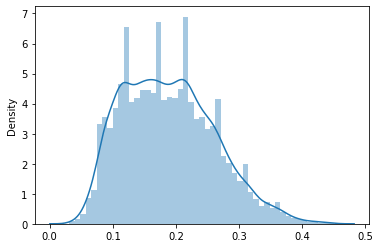

In [65]:
#ploting distribution plot of pixel values of first channel of first image, blured
sns.distplot(blured_images[0,:,:,0])

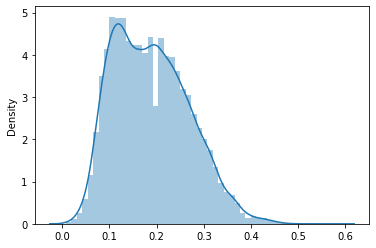

In [68]:
#ploting distribution plot of pixel values of first channel of first image, normalized
sns.distplot(images[0,:,:,0].astype('float32')/255.0)

It is noticable from histograms above how bluring changed distribution of pixel values in image. Above plots shows same image, same channel, but upper one is for blured image. If upper image is compared to lower one, the most noticable difference is the range of pixel values. BLured image has lower range of pixel values. It could be explained by loss of sharp edges by applying blur technique, hence averaging and consequently removing "extreme" values.
In addition, the distribution of pixel values in blured image favored at least 3 (+2) distinct pixel value ranges. 

##3. Make data compatible

####a. Convert labels to one-hot-vectors.

In [70]:
#counts of all values present in labels
labels_df.value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Label                          1
dtype: int64

In [71]:
#number of unique values of labels
len(pd.unique(labels_df[0]))

13

In [72]:
#unique label values
pd.unique(labels_df[0])

array(['Label', 'Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

As it can bee seen, there are 13 unique values, however, value 'Label' is not valid, so final number of unique valid values is 12

Labels are of type string. For 'to_categorical' to be usable, all labels needs to be converted into int values. To do so, a dictionary of valid labels will be set with int value for each label in dictionar. Later, such dictionary will be used to assign integer value to each label in labels array. Such dictionary can be later used to reverse process - all labels will be preserved, and once the result is obtained, it can be easily converted into labels.

In [73]:
#list of valid labels are generated from unique values in labels_df (pandas df was used so unique function could be applied)
valid_labels=pd.unique(labels_df[0])

In [74]:
#'label' value must be deleted
valid_labels=np.delete(valid_labels, 0)

In [75]:
#generating a dict for mapping between valid_labels and integer numbers
mapping={}
for i in range (len(valid_labels)):
  mapping[valid_labels[i]]=i

In [76]:
#dictionary with labels and corresponding integer value
mapping

{'Black-grass': 10,
 'Charlock': 5,
 'Cleavers': 6,
 'Common Chickweed': 4,
 'Common wheat': 3,
 'Fat Hen': 1,
 'Loose Silky-bent': 11,
 'Maize': 9,
 'Scentless Mayweed': 7,
 'Shepherds Purse': 2,
 'Small-flowered Cranesbill': 0,
 'Sugar beet': 8}

In [77]:
#int_labels is declared. It will be a list which will be passed to to_categorical()
int_labels=[]
#assigning integer values to labels from labels array
for i in range(len(labels)):
  #revoking int value of corresponding label and appending with such value int_labels list 
  int_labels.append(mapping[labels[i][0]])

In [78]:
#applying one_hot_encoding function of KERAS (to_categorical())
one_hot_encoded_labels=to_categorical(int_labels)

In [79]:
#y variable
one_hot_encoded_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

####b. Print the label for y_train[0].

y_train will be generated when train_test_split will be made. In this stage one_hot_encoded contains all output data in a one_hot_encoded form.

In [80]:
one_hot_encoded_labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

To extract textual label, code below is used. It search keys by providing index of targeted value.

In [81]:
for i in range(len(one_hot_encoded_labels[0])):
  if one_hot_encoded_labels[0][i]==1:
    #retrieving key value from mapping dictionary for y_train[0]
    print(list(mapping.keys())[list(mapping.values()).index(i)])

Small-flowered Cranesbill


In [82]:
#checking if the result is the same to the one obtained directly from labels variable
labels[0][0]

'Small-flowered Cranesbill'

####c. Split the dataset into training, testing, and validation set.

First split will divide dataset into training and test dataset in ratio70-30. Afterwards test dataset will be divided into test and validation sets in ration 50-50. Stratified strategy is used to preserve ratio of classes among train, test, validation datasets. 

In [83]:
#splitting data into train and test sets in portion of 0.7 - 0.3, using random_state=7 and applying stratified strategy taking into account target variable one_hot_encoded_labels
X_train, X_test, y_train, y_test = train_test_split(blured_images, one_hot_encoded_labels, test_size=0.30, random_state=7, stratify=one_hot_encoded_labels)

In [84]:
print('Shape of the X_train is',X_train.shape)
print('Shape of the y_train is',y_train.shape)

print('Shape of the X_test is',X_test.shape)
print('Shape of the y_test is',y_test.shape)

Shape of the X_train is (3325, 128, 128, 3)
Shape of the y_train is (3325, 12)
Shape of the X_test is (1425, 128, 128, 3)
Shape of the y_test is (1425, 12)


In [85]:
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.50, random_state=7, stratify=y_test)

In [86]:
print('Shape of the X_test is',X_test.shape)
print('Shape of the y_test is',y_test.shape)

print('Shape of the X_validation is',X_validation.shape)
print('Shape of the y_validation is',y_validation.shape)

Shape of the X_test is (712, 128, 128, 3)
Shape of the y_test is (712, 12)
Shape of the X_validation is (713, 128, 128, 3)
Shape of the y_validation is (713, 12)


####d. Check the shape of data, Reshape data into shapes compatible with Keras models if it’s not already. If it’s already in the compatible shape, then comment in the notebook that it’s already in compatible shape.


In [87]:
#shape of datasets
print('Shape of the X_train is',X_train.shape)
print('Shape of the y_train is',y_train.shape)

print('Shape of the X_test is',X_test.shape)
print('Shape of the y_test is',y_test.shape)

print('Shape of the X_validation is',X_validation.shape)
print('Shape of the y_validation is',y_validation.shape)

Shape of the X_train is (3325, 128, 128, 3)
Shape of the y_train is (3325, 12)
Shape of the X_test is (712, 128, 128, 3)
Shape of the y_test is (712, 12)
Shape of the X_validation is (713, 128, 128, 3)
Shape of the y_validation is (713, 12)


Input data is already in compatible shape, since CNN part of the network accept input shape of the data we have - we can set input shape to be (128,128,3) - 128x128 pixels with RGB channels. Output of the CNN part has to be adjusted for DNN part of the network by applying Flatten() or GlobalMaxPooling2D(). 
If Flatten is used, it will, most probably, generate huge number of dimnesions for DNN to start with. 
Shape of the y variable is suitable for softmax activated layer of DNN, where there will be 12 output nodes.

It is worth noting at this stage there was no classic EDA applied here, like null or missing values becuase it is assumed all images are valid. In addition there was no analysis of outliers perfomed as dataset is composed of images, so no outliers are expected.  

##4. Building CNN: (15 Marks)


####a. Define layers

In [ ]:
#defining input shape as 128x128 pixels for R,G,B 
input_shape=(128, 128, 3)

#number of output neurons of DNN equals number of classes
num_classes=len(valid_labels)

In [ ]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(5,5), padding='same', kernel_initializer='normal', strides=(1,1), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(5,5), strides=(1,1), padding='same', kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3), strides=(1,1), padding='same', kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(64,(3,3), strides=(1,1), padding='same', kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

#last layer of CNN part of network
model.add(GlobalMaxPooling2D())
#model.add(Flatten())




#DNN part


model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(layers.Dropout(0.5))

model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(layers.Dropout(0.5))

#setting output layer with softmax as activation function. Number of output neurons is equal to number of classes
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_46 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_47 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 32, 32, 64)      

Two approaches were used to build NN. First approach was to use Flatten() layer. This approach resulted in huge number of trainable parameteres, because final output from CNN part was huge - it depended on size of activation map resulting from last MaxPooling layer of CNN multiplied with numbers of kernels. This resulted in huge number of weightes to be learned in first hidden layer of DNN, regardles of the number of neurons in it (because of huge number of dimensions as a result of flatten layer as desribed above). To avoid such huge number of paramteres to be learnt, GlobalMaxPooling2D was used as last layer of CNN.

####b. Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)


In [ ]:
#setting Adam optimizer as optimizer which will be used for training the model. Initially, learning rate is set to 0.001
optimizer = Adam(learning_rate=0.0001)

In [ ]:
#creating a model whit loss functiona s categorical_crossentropy, suitable for multivariate categories. Metrics used is accuracy.
model.compile(loss=categorical_crossentropy, optimizer=optimizer,metrics=['accuracy'] )

### 5. Fit and evaluate model and print confusion matrix

Model is fitted with X_train and y_train sets. For validation, X_validation and y_validation is used. Validation sets have been obtained by splitting test sets into 2 sets - test and validation, each set containing equal number of samples

In [ ]:
history=model.fit(X_train, y_train, epochs=300, validation_data=(X_validation, y_validation))

Epoch 1/300
104/104 [==============================] - 7s 71ms/step - loss: 3.4056 - accuracy: 0.0938 - val_loss: 2.4679 - val_accuracy: 0.1052
Epoch 2/300
104/104 [==============================] - 6s 60ms/step - loss: 2.6724 - accuracy: 0.1200 - val_loss: 2.4646 - val_accuracy: 0.1346
Epoch 3/300
104/104 [==============================] - 6s 60ms/step - loss: 2.5089 - accuracy: 0.1386 - val_loss: 2.4536 - val_accuracy: 0.1487
Epoch 4/300
104/104 [==============================] - 6s 59ms/step - loss: 2.3913 - accuracy: 0.1723 - val_loss: 2.4295 - val_accuracy: 0.2132
Epoch 5/300
104/104 [==============================] - 6s 59ms/step - loss: 2.3306 - accuracy: 0.2135 - val_loss: 2.3893 - val_accuracy: 0.2735
Epoch 6/300
104/104 [==============================] - 6s 59ms/step - loss: 2.2273 - accuracy: 0.2472 - val_loss: 2.3186 - val_accuracy: 0.2973
Epoch 7/300
104/104 [==============================] - 6s 59ms/step - loss: 2.1391 - accuracy: 0.2806 - val_loss: 2.2470 - val_accuracy:

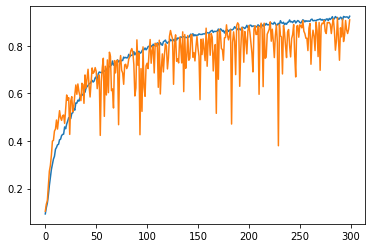

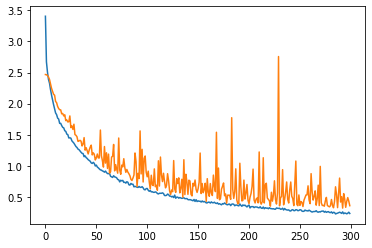

In [ ]:
plt.plot(history.history.get('accuracy'))
plt.plot(history.history.get('val_accuracy'))
plt.show()
plt.plot(history.history.get('loss'))
plt.plot(history.history.get('val_loss'))
plt.show()

After some testing and trying, learning rate has been adjusted from 0.01 to 0.0001. Number of epochs have been significantly increased to allow enough tries for alghoritm to converge to a minimum loss. Graphs above shows significant fluctuation in losses and accuracy on train and validation tests, however one follows the other. There was significant overfit problem which was solved by adding Dropout layer after each MaxPooling in CNN part or dense layer in DNN part. To furher increase accuracy on both, train and validation data number of epochs might be increased, since it looks from the graphs above, minimum loss has not been reached(second graph). In addition, Model Checkpoint callback to the fit function would save the weights whenever val_loss achieves a new low value. Hence saving the best weights occurred during training [1]

[1] https://olympus.greatlearning.in/courses/20484/files/1162372?module_item_id=721651

To evaluate model, test data is used, stored in X_test and corresponding y_test variables. Test datasets are obtained by splitting test data into test and validation data in ratio 50-50. Validation dataset was used to develop better network which is not overfit or underfit. For that reason, validation dataset is not used here.

In [ ]:
#evaluating model
#scores are preserved in score variable
#test data is used for evaluation. This is dataset which hasn't been used in trainning process, while hyper paramteres were adjusted and network architecture developed
scores=model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 1s 28ms/step - loss: 0.3291 - accuracy: 0.9045
Test loss: 0.3291129767894745
Test accuracy: 0.9044944047927856


As one can see, test accuracy is around 90.5% on test data, which is comparable with result achieved on train dataset as well (~92%).

In [ ]:
#predict gives probabilities for each class for given input image array - it gives an array of probabilities array
y_predict=model.predict(X_test)

In [ ]:
#predict_classes gives predicted class - it is an array of classes from 0-12 for given input image array
y_predict_classes=model.predict_classes(X_test)

Above 2 lines of code gives two distinct results. First line gives as an output an array of probabilities that input image is of certain class. Shape of such output is equal to the number_of_input_images*number_of_classes. It is 2 dimensional array.
Second line gives as an output an array of classes (from 0 to 11) for all input images - it is 1 dimensional array of values. Second one is useful to be used by confusion matrix to represent true_predicted vs false_predicted. 

In [ ]:
#how y_predict_classes looks like
y_predict_classes

array([ 0,  4,  7,  8, 11, 11,  7, 11, 10,  8,  5,  4, 11,  8,  2,  0,  0,
       11, 11,  4,  7, 11,  6,  7,  5,  7,  4,  0,  3, 11,  2,  5,  5, 10,
       11,  5, 11,  0,  1,  0, 11,  2,  0,  8,  8,  5,  1,  8,  5,  4,  7,
        8,  7, 10, 11, 11,  8,  8,  8,  7,  7,  4,  0,  0,  2,  1,  8,  4,
        5,  7,  4,  4,  1,  7, 11,  1,  4,  7,  8,  9,  4,  5,  7,  7,  9,
        8,  3,  2,  3,  7,  3,  1,  1,  0,  5,  1,  2, 11,  0,  9,  1,  0,
        9,  0,  4,  7,  0,  5,  0, 11,  2,  3,  1,  4, 11, 11,  6,  2,  4,
        7,  7,  8, 11,  8, 11,  0,  4,  1,  4,  2,  8,  1,  9,  1,  8,  2,
        3,  5,  6, 11,  0,  6, 11,  2,  7,  2,  3,  0,  0,  5,  1, 11,  0,
        7,  7,  7,  7,  6,  1,  8, 11,  7,  7,  7,  0,  4,  4,  0,  7, 11,
        2,  3,  5,  5, 11,  1, 10,  3,  7,  9,  8,  8,  8,  5, 11,  0,  0,
        2,  5,  4,  8,  6, 11,  5,  8,  0, 11,  1,  4,  0,  7,  5,  3,  4,
       11,  1, 11,  0,  4, 10,  8,  1, 11, 11, 11,  7, 10,  3,  5,  7,  7,
       11, 10,  8, 11, 11

In [ ]:
#retrieving y_true array
y_true=[]
for i in y_test:
  for j in range(len(i)):
    if i[j]==1:
      y_true.append(j)

Code above is used to retrieve integer number of class to which that index belongs to. It is done by assigning index of array of y_test to y_true. The reason it had to be done lies in a fact that y_test is 2D array of one_hot_encoded variables, but for confusion matrix we need integer value of a class (from 0 to 11). Y_test is used because it is the only dataset that correspond to X_test dataset. 

In [ ]:
#converting y_true to numpy array
y_true=np.array(y_true)

In [ ]:
#calculating confusion matrix
cm=confusion_matrix(y_true, y_predict_classes)

In [ ]:
#printing confusion matrix
cm

array([[71,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 69,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 30,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  4,  0, 82,  0,  0,  5,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  0, 53,  0,  0,  4,  0,  0,  0],
       [ 1,  0,  0,  1,  0,  2, 37,  0,  1,  0,  0,  1],
       [ 0,  0,  1,  0,  0,  0,  0, 74,  0,  0,  0,  2],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 57,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  0, 31,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  1,  0,  0, 23, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  7, 85]])

As one can see in confussion matrix above, most of the values are on diagonal of it. It means, most of the labels were assigned correctly. E.g. images labeled with "3" has 32 correct predictions. 
Confussion matrix correspond to achieved accuracy (only 10% of values are incorrect).

###6. Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

In [ ]:
#function which returns label based on integer value. mapping dictionary is used for the same
def return_name_of_class(class_number):
  return(list(mapping.keys())[list(mapping.values()).index(class_number)])

In [ ]:
#function that takes image array, index, predicted label and true label and plot corresponding image and predicted and true labels
def correlate_image_label(image_array, index, label_predict, label_true):
  #to show image, array needs to be multiplied with 255 because of normalization done before fiting the model
  cv2_imshow(image_array[index]*255)
  print ("Predicted label is", return_name_of_class(label_predict[index]))
  print ("True label is", return_name_of_class(label_true[index]))

Images are visualized and corresponding labels printed from both - predicted and true values. y_predict_classes array respresent predicted labels while y_true represent true values. Functions above are used to visualize images from test dataset to make code more readable. Description of thhe functions above are provided in form od comments inside of code.

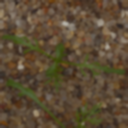

Predicted label is Scentless Mayweed
True label is Scentless Mayweed


In [ ]:
correlate_image_label(X_test, 2, y_predict_classes, y_true)

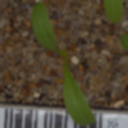

Predicted label is Sugar beet
True label is Sugar beet


In [ ]:
correlate_image_label(X_test, 3, y_predict_classes, y_true)

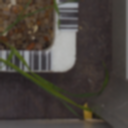

Predicted label is Black-grass
True label is Black-grass


In [ ]:
correlate_image_label(X_test, 33, y_predict_classes, y_true)

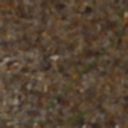

Predicted label is Loose Silky-bent
True label is Black-grass


In [ ]:
correlate_image_label(X_test, 36, y_predict_classes, y_true)

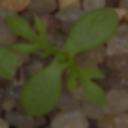

Predicted label is Scentless Mayweed
True label is Scentless Mayweed


In [ ]:
correlate_image_label(X_test, 59, y_predict_classes, y_true)